# A toy example

In [ ]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np 
import matplotlib.pyplot as plt


## Data

[[248.06932907]
 [252.75508974]
 [247.03817793]
 ...
 [249.93453281]
 [252.41781184]
 [254.36445147]]


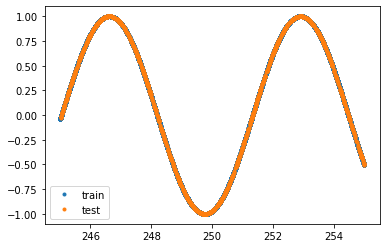

In [ ]:
data = np.random.uniform(size=(64 * 1025, 1), low=-5., high=5.) + 250.

x_train = data[:64*1000, :]
x_test = data[64*1000:, :]

y_train = np.sin(x_train) #+ np.random.normal(size=x_train.shape) / 10.
y_test = np.sin(x_test)

mean_train = np.mean(x_train)
var_train = np.var(x_train)

plt.plot(x_train, y_train, '.')
plt.plot(x_test, y_test, '.')
plt.legend(["train", "test"])

#x_train = (x_train - mean_train) / var_train
#x_test = (x_test - mean_train) / var_train

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

print(x_train)


## Model

In [ ]:
class MyDenseLayer(keras.layers.Layer):
  def __init__(self, units=32):
    super(MyDenseLayer, self).__init__()
    self.units=units
  def build(self, input_shape):
    w_init = tf.initializers.glorot_uniform()
    self.w = tf.Variable(
        initial_value=w_init(shape=(input_shape[-1], self.units), dtype="float32"), trainable=True
    )
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(
        initial_value=b_init(shape=(self.units, ), dtype="float32"), trainable=True
    )
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

In [ ]:

inputs = keras.Input(1, name="input_layer")
hidden_layer_1 = MyDenseLayer(units=3)
hidden_layer_2 = MyDenseLayer(units=3)
output_layer = MyDenseLayer(1)

x = (inputs - mean_train) / tf.sqrt(var_train)
x = hidden_layer_1(x)
x = tf.tanh(x)
x = hidden_layer_2(x)
x = tf.tanh(x)
outputs = output_layer(x)

model = keras.Model(inputs=inputs, outputs=outputs)

def my_loss(y_true, y_pred):
  return tf.math.reduce_mean((y_true - y_pred) ** 2)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=my_loss,
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [ ]:
xx = model(np.array([[1.]]))
print(xx)

print(hidden_layer_2.weights)

tf.Tensor([[-0.33173436]], shape=(1, 1), dtype=float32)
[<tf.Variable 'my_dense_layer_25/Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.9768195 ,  0.3659048 ,  0.51458025],
       [ 0.73311424, -0.31763983,  0.29210424],
       [-0.6866455 , -0.88241005,  0.13123322]], dtype=float32)>, <tf.Variable 'my_dense_layer_25/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


## Training

In [ ]:
logdir = "log/toy_example"
tensorboard_callback = keras.callbacks.TensorBoard(logdir)

model.fit(
    train_dataset,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback]
)

Epoch 1/10
1000/1000 [==============================] - 2s 1ms/step - loss: 0.4419 - root_mean_squared_error: 0.6648 - val_loss: 0.3935 - val_root_mean_squared_error: 0.6273
Epoch 2/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1125 - root_mean_squared_error: 0.3211 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 3.7186e-04 - val_root_mean_squared_error: 0.0193
Epoch 4/10
1000/1000 [==============================] - 1s 1ms/step - loss: 2.5874e-04 - root_mean_squared_error: 0.0160 - val_loss: 8.4072e-05 - val_root_mean_squared_error: 0.0092
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/step - loss: 9.5724e-05 - root_mean_squared_error: 0.0098 - val_loss: 7.1192e-05 - val_root_mean_squared_error: 0.0084
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/step - loss: 9.4859e-05 - root_mean_squared_err

(100,)
(100, 1)


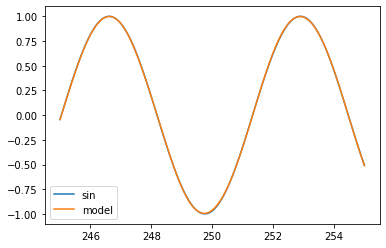

In [ ]:
x = np.linspace(-5., 5., 100) + 250.

plt.plot(x, np.sin(x))

print(x.shape)

x = np.reshape(x, (-1, 1))

print(x.shape)

plt.plot(x, model(x))

plt.legend(["sin", "model"])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
tf.math.subtract_11 (TFOpLam (None, 1)                 0         
_________________________________________________________________
tf.math.truediv_11 (TFOpLamb (None, 1)                 0         
_________________________________________________________________
my_dense_layer_24 (MyDenseLa (None, 3)                 6         
_________________________________________________________________
tf.math.tanh_18 (TFOpLambda) (None, 3)                 0         
_________________________________________________________________
my_dense_layer_25 (MyDenseLa (None, 3)                 12        
_________________________________________________________________
tf.math.tanh_19 (TFOpLambda) (None, 3)                 0   

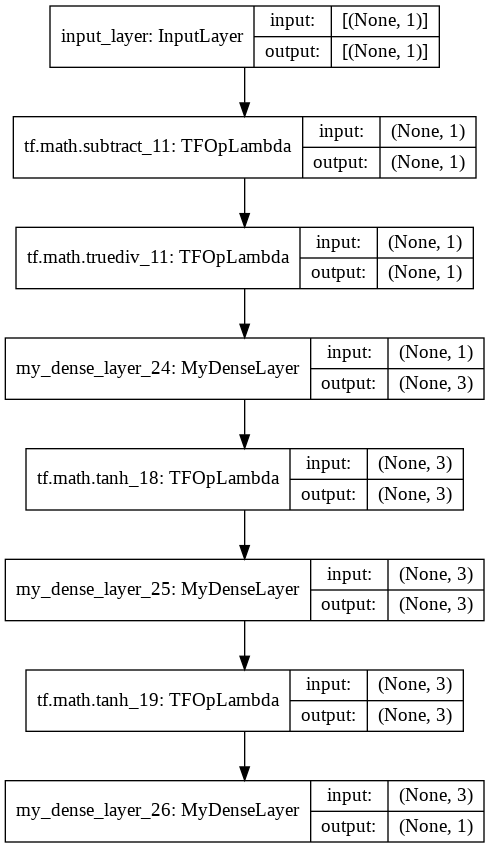

In [ ]:
model.summary()

keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir log